In [1]:
import pandas as pd
from  wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics.pairwise import linear_kernel,cosine_similarity

In [2]:
movies = pd.read_csv("../../../../DataSets/ml-latest/movies.csv")
ratings = pd.read_csv("../../../../DataSets/ml-latest/ratings.csv")
tags = pd.read_csv("../../../../DataSets/ml-latest/tags.csv")
links = pd.read_csv("../../../../DataSets/ml-latest/links.csv")
g_tags = pd.read_csv("../../../../DataSets/ml-latest/genome-tags.csv")
g_scores = pd.read_csv("../../../../DataSets/ml-latest/genome-scores.csv")

In [3]:
movies['year'] = movies['title'].str.extract('.*\((.*)\).*',expand = False)
movies['year'] = movies['year'].str.extract('(\d+)', expand=False)
movies.dropna(inplace=True)
movies['year'] = movies['year'].astype(int)
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


In [4]:
final_df = movies
final_df["userid"] = ratings["userId"]
final_df["rating"] = ratings["rating"]
final_df["tag"] = tags["tag"]
# final_df["g_tag"] = g_tags["tag"]

In [5]:
final_df.dropna(inplace=True)
final_df.isna().sum()

movieId    0
title      0
genres     0
year       0
userid     0
rating     0
tag        0
dtype: int64

In [6]:
final_df = final_df.drop(["movieId"], axis=1)


In [7]:
final_df.head()

,title,genres,year,userid,rating,tag
0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,1,3.5,epic
1,Jumanji (1995),Adventure|Children|Fantasy,1995,1,3.5,Medieval
2,Grumpier Old Men (1995),Comedy|Romance,1995,1,1.5,sci-fi
3,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,1,4.5,space action
4,Father of the Bride Part II (1995),Comedy,1995,1,4.5,imdb top 250


In [8]:
final_df.shape

(57772, 6)

In [9]:
final_df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57772 entries, 0 to 58097
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   title   57772 non-null  object 
 1   genres  57772 non-null  object 
 2   year    57772 non-null  int32  
 3   userid  57772 non-null  int64  
 4   rating  57772 non-null  float64
 5   tag     57772 non-null  object 
dtypes: float64(1), int32(1), int64(1), object(3)
memory usage: 2.9+ MB


In [10]:
title_corp = ' '.join(final_df["title"])

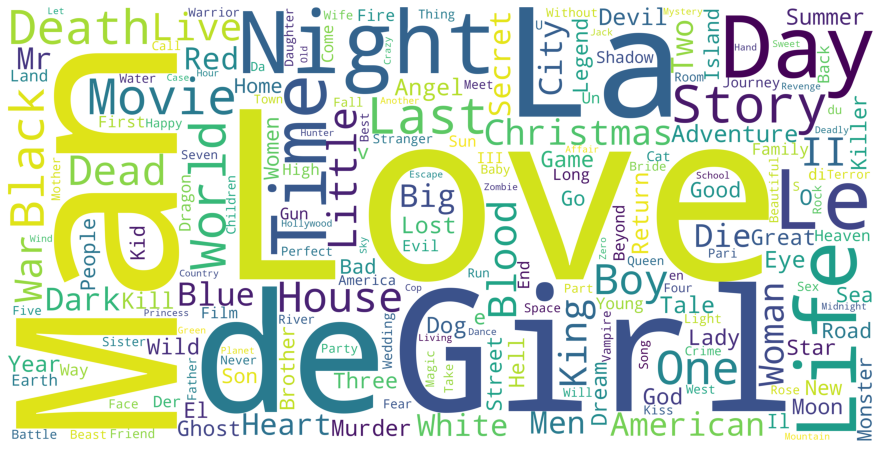

In [11]:
title_wc = WordCloud(stopwords=STOPWORDS, background_color='white',
                            height=2000, width=4000).generate(title_corp)
plt.figure(figsize=(16, 8))
plt.imshow(title_wc)
plt.axis('off')
plt.show()


In [12]:
tag_corp = ' '.join(final_df["tag"])


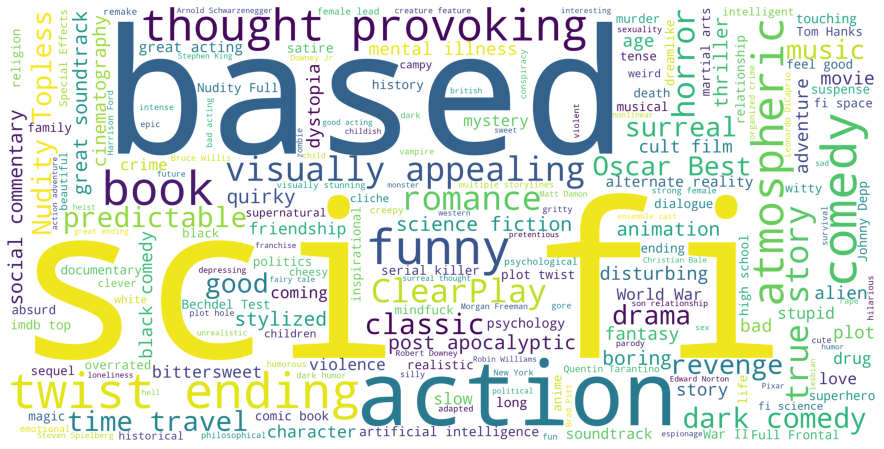

In [13]:
tag_wc = WordCloud(stopwords=STOPWORDS, background_color='white',
                     height=2000, width=4000).generate(tag_corp)
plt.figure(figsize=(16, 8))
plt.imshow(tag_wc)
plt.axis('off')
plt.show()


In [14]:
final_df[['title', 'rating']].sort_values('rating', ascending=False).head(10)


,title,rating
40357,Swamp Zombies!!! (2005),5.0
18762,"Pearl, The (La perla) (1947)",5.0
18799,Happy End (1967),5.0
43102,Golden Mouth (1963),5.0
18775,Latin Music USA (2009),5.0
53280,Dream Boat (2017),5.0
43107,The Wooden Horse (1950),5.0
18764,Rollo and the Woods Sprite (Rölli ja metsänhen...,5.0
18763,"Summer by the River, A (Kuningasjätkä) (1998)",5.0
18760,The Artist (2008),5.0


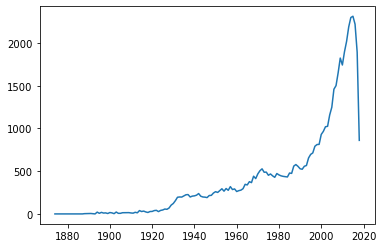

Max No.of Movies Relesed = 2312
year = 2015


count     134.000000
mean      431.134328
std       546.779743
min         1.000000
25%        29.250000
50%       262.000000
75%       502.000000
max      2312.000000
Name: title, dtype: float64

In [15]:
plt.plot(final_df.groupby('year').title.count())
plt.show()
a = final_df.groupby('year').title.count()
print('Max No.of Movies Relesed =', a.max())
for i in a.index:
    if a[i] == a.max():
        print('year =', i)
a.describe()


#### Content Based Filtering
There are two types of filtering in content based movie recommendation
1. Description Based - Based on textual description of the movie or the taglines/punchlines
2. Meta data based - Genre, Keywords etc <br />
As we only have metadata of the movies, we will work with Meta Data based filtering

In [16]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(final_df['tag'])
tfidf_matrix.shape

(57772, 15837)

In [17]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[0]


array([1., 0., 0., ..., 0., 0., 0.])

In [18]:
final_df=final_df.reset_index()
titles=final_df['title']
indices=pd.Series(final_df.index,index=final_df['title'])

In [19]:
def get_recommendation(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]


In [22]:
get_recommendation('Happy End').head(10)


KeyError: 'Happy End'